# An Introduction to BioImage Data Analysis with Python

developed by *Jonas Hartmann (Gilmour group, EMBL Heidelberg)*<br>
as part of the EMBL Bio-IT Course on [**Intermediate Python Programming**](https://bio-it.embl.de/events/intermediate-python-programming/)<br>
20.09.2017

----

## About

### Purpose

This tutorial introduces a number of tools and strategies for image analysis (specifically fluorescence microscopy images as produced in the biosciences) available in python. It aims to give the course attendees a starting point to further explore image analysis packages and pipelines. Furthermore, it serves as another practical example of scientific python programming.


### Format

In the course, teacher and students develop the pipeline below together in an open session over the course of about two hours. The tutorial can also be used for self-study, which is best done by re-implementing, testing and playing around with each step of the pipeline.


### Content

The tutorial pipeline encompasses the following parts:

1. Loading & viewing images
2. Image processing & segmentation
3. Data Extraction & analysis

It is based on an example **3-channel image** of **human HT29 colon cancer cells** in culture, labeled with...

- Hoechst stain (DNA)
- Phalloidin (actin)
- Histone H3 phosphorylated on serine 10 [pH3] antibody (mitosis marker)

The example image was obtained from the [CellProfiler website](http://cellprofiler.org/examples/#HumanCells) and derives from [Moffat et al., 2006].


### Dependencies

- python (2.7 or 3.x)
- numpy, scipy, matplotlib
- skimage, pandas, sklearn

All packages used in this tutorial are part of the [Anaconda](https://www.anaconda.com/distribution/) distribution of python.

## 1. Loading & Viewing Images

### 1a. Imports

In [1]:
# For python 2 users
from __future__ import division, print_function 

# Scientific python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image analysis
import scipy.ndimage as ndi
from skimage import io, segmentation, graph, filters, measure

# Machine learning
from sklearn import preprocessing, svm, metrics

### 1b. Loading Image Data

In [2]:
# Read data
raw = io.imread('HT29.tif')

# Check data structure and type
print(raw.shape)
print(raw.dtype)

# Split channels
nuc = raw[:,:,0]
pH3 = raw[:,:,1]
act = raw[:,:,2]

(512L, 512L, 3L)
uint8


### 1c. Viewing Image Data

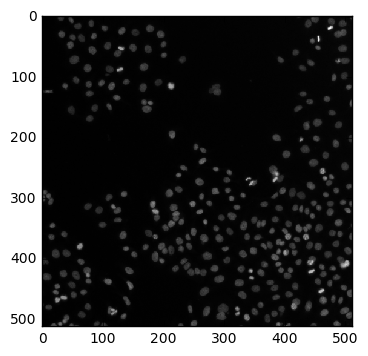

In [3]:
# Simple imshow
plt.imshow(nuc, interpolation='none', cmap='gray')
plt.show()

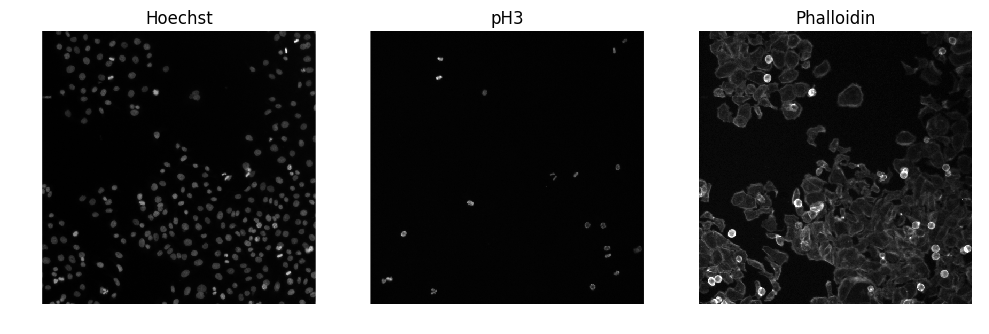

In [4]:
# Nice subplots
fig,ax = plt.subplots(1, 3, figsize=(12,4))
for axis,image,title in zip(ax, [nuc,pH3,act], ['Hoechst','pH3','Phalloidin']):
    axis.imshow(image, interpolation='none', cmap='gray')
    axis.set_title(title)
    axis.axis('off')
plt.show()

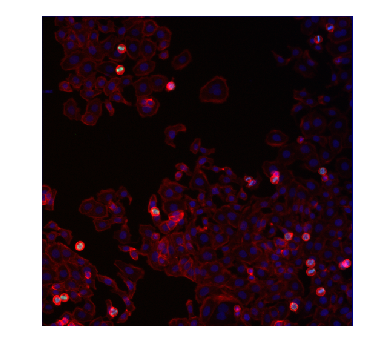

In [5]:
# Colored overlay using rgb
fig = plt.figure(figsize=(4,4))
plt.imshow(np.zeros_like(nuc), vmax=1)    # Black background
rgb = np.zeros(image.shape+(3,))          # Empty RGB
for i,image in enumerate([act,pH3,nuc]):  # Add each channel to RGB
    rgb[:,:,i] = (image.astype(np.float) - image.min()) / (image.max() - image.min()) # Normalize images to [0,1]
plt.imshow(rgb, interpolation='none')
plt.axis('off')
plt.show()

## 2. Image Processing & Segmentation

### 2a. Preprocessing by Smoothing

Smoothing an image to reduce technical noise is almost always the first step in image analysis. The most common smoothing algorithm is the **Gaussian filter**.

The Gaussian filter is an example of a key technique of image analysis: **kernel convolution**. In image analysis, a **kernel** is a small 'mask' that is **moved over each pixel in the image**. At each pixel position, the kernel determines **which** of the surrounding pixels are used to compute the new value and **how much** each surrounding pixel contributes. Kernel convolutions can be implemented using Fast Fourier Transforms (FFTs), which makes them very fast.

For the **Gaussian filter**, the kernel is a small Gaussian-like distribution (fig. 1). To compute a pixel of the smoothed image, the values of the surrounding pixels are multiplied by the corresponding kernel value, summed up, and normalized again (by dividing by the sum of kernel values). Thus, by 'diluting' the values of individual pixels with the values of neighboring pixels, a convolution with a Gaussian kernel leads to a smoothing of the image.

<br><img src="..\pictures\gaussian_kernel_grid.png" alt="Gaussian Filter Kernel" style="width: 300px">

<center>**Fig 1:** Example of a Gaussian convolution kernel.

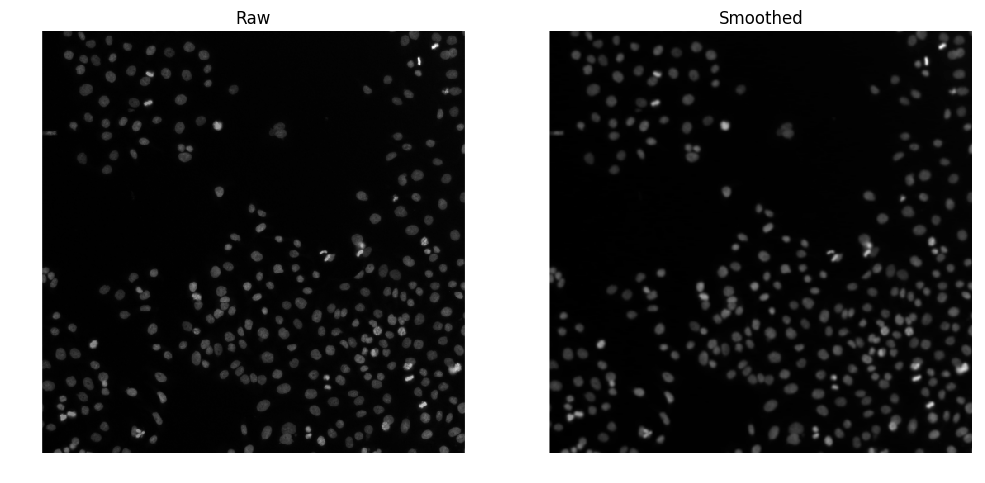

In [6]:
# Gaussian smoothing
nuc_smooth = ndi.gaussian_filter(nuc, sigma=1)

# Show
fig,ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(nuc, interpolation='none', cmap='gray')
ax[0].set_title('Raw')
ax[0].axis('off')
ax[1].imshow(nuc_smooth, interpolation='none', cmap='gray')
ax[1].set_title('Smoothed')
ax[1].axis('off')
plt.show()

### 2b. Simple Nucleus Segmentation

A simple way of segmenting nuclei in these images is to combine **adaptive background subtraction** and **thresholding**.

The idea of **adaptive background subtraction** is to compute a **local background** for each position of the image. If there is a slow continuous change in the image background, the local background can be adjusted for this, hence evening out the image.

A simple way of computing the local background is a **convolution** with a relatively large **uniform (mean)** kernel (fig. 2). If this kernel is large compared to the structures in the image, the mean will usually end up lower than the foreground but higher than the background - perfect for background subtraction.

<br><img src="..\pictures\uniform_kernel_grid.png" alt="Uniform Filter Kernel" style="width: 300px">

<center>**Fig 2:** Example of a circular uniform convolution kernel.

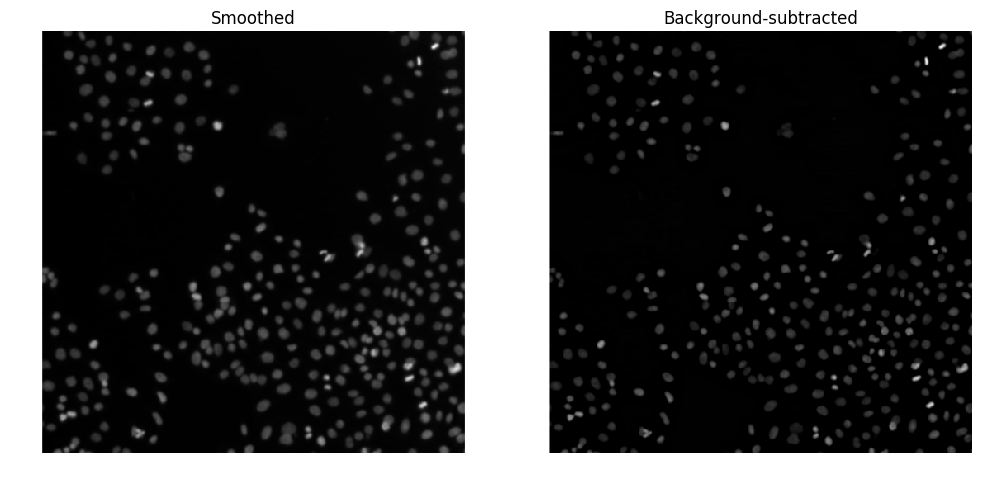

In [7]:
# Adaptive background subtraction
nuc_smooth_bg = ndi.uniform_filter(nuc_smooth, size=20)
nuc_smooth_bgsub = nuc_smooth - nuc_smooth_bg
nuc_smooth_bgsub[nuc_smooth < nuc_smooth_bg] = 0

# Show
fig,ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(nuc_smooth, interpolation='none', cmap='gray')
ax[0].set_title('Smoothed')
ax[0].axis('off')
ax[1].imshow(nuc_smooth_bgsub, interpolation='none', cmap='gray')
ax[1].set_title('Background-subtracted')
ax[1].axis('off')
plt.show()

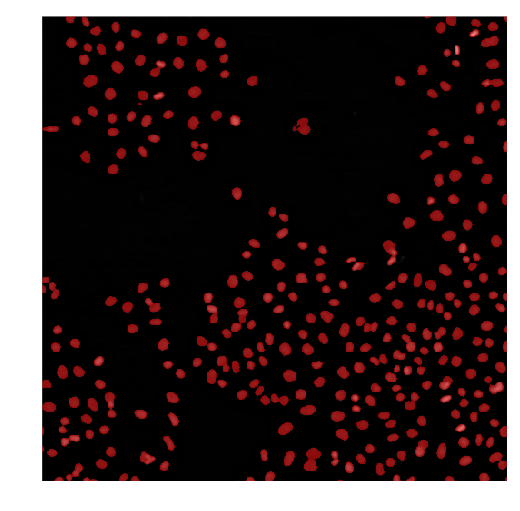

In [8]:
# Interactive search for a good threshold

# Plotting function
def threshold_plot(threshold=10):
    
    # Threshold
    nuc_mask = nuc_smooth_bgsub > threshold

    # Show
    fig = plt.figure(figsize=(6,6))
    plt.imshow(nuc_smooth_bgsub, interpolation='none', cmap='gray')
    plt.imshow(np.ma.array(nuc_mask, mask=nuc_mask==0), interpolation='none', cmap='autumn', alpha=0.5)
    plt.axis('off')
    plt.show()    
    
    
# Interactive widget
from ipywidgets import interactive
interactive(threshold_plot, threshold=(1,255,1))

In [9]:
# Apply threshold
nuc_mask = nuc_smooth_bgsub > 10

**Note:** There are a number of problems with a simple segmentation like this, namely the risk of **fused nuclei** and of **artefacts**, e.g. small debris or background fluctuations that are wrongly considered a nucleus. There are a number of ways to address these problems but for the purpose of this course we will consider the current result good enough.

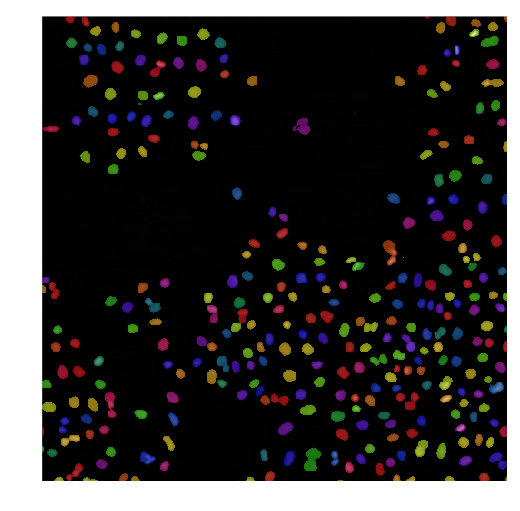

In [10]:
# Label the image to give each object a unique number
nuc_labeled = ndi.label(nuc_mask)[0]

# Show
fig = plt.figure(figsize=(6,6))
plt.imshow(nuc_smooth_bgsub, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(nuc_labeled, mask=nuc_labeled==0), interpolation='none', cmap='prism', alpha=0.5)
plt.axis('off')
plt.show()  

### 2c. Cell Segmentation by Watershed

For many structures, simply filtering and thresholding the image is not enough to get a segmentation. In these cases, one of many alternatives must be applied.

A very common approach is the **watershed** algorithm (fig. 3), which works by treating the image as a **topographical map** and slowly filling up the valleys in the map with water, starting from so-called **seeds**. Wherever the waterfronts of two different seeds meet, the boundary between these two objects is generated.

Here we can use the **labeled nuclei** as seeds for a watershed segmentation of the cells based on the **phalloidin channel**.


<br><img src="..\pictures\watershed_illustration.png" alt="Watershed Explanation" style="width: 900px">

<center>**Fig 3:** Graphical explanation of watershed segmentation.</center>

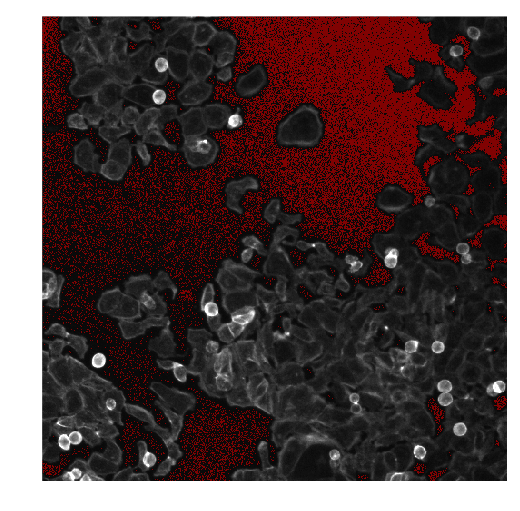

In [11]:
# Identify a background seed
# Here, the 5th percentile on signal intensity is used.
act_bgsub = act - np.percentile(act,5)
act_bgsub[act < np.percentile(act,5)] = 0

# Show
fig = plt.figure(figsize=(6,6))
plt.imshow(act, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(act_bgsub==0, mask=act_bgsub!=0), interpolation='none', cmap='autumn', alpha=0.5)
plt.axis('off')
plt.show()

In [12]:
# Prepare the seeds
seeds = np.copy(nuc_labeled)               # Cell seeds
seeds[act_bgsub==0] = nuc_labeled.max()+1  # Add background seeds

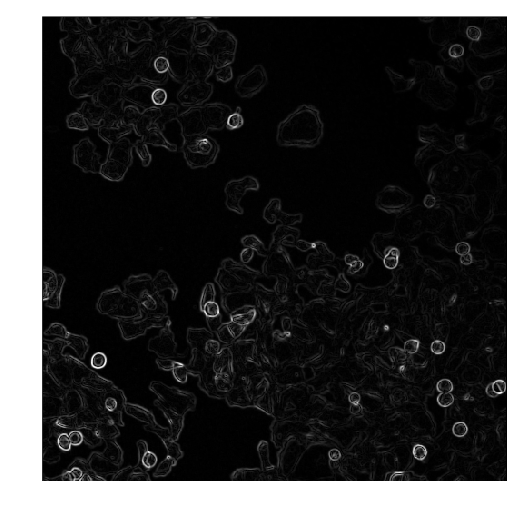

In [13]:
# Prepare the image by Sobel edge filtering
act_sobel = filters.sobel(act_bgsub)

# Show
fig = plt.figure(figsize=(6,6))
plt.imshow(act_sobel, interpolation='none', cmap='gray')
plt.axis('off')
plt.show()

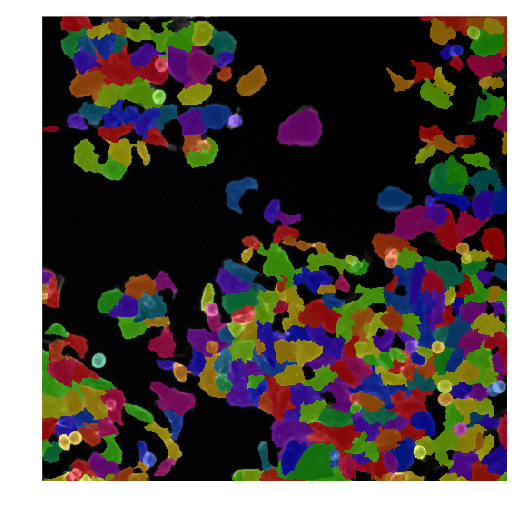

In [14]:
# Run watershed
act_ws = segmentation.watershed(act_sobel, seeds)

# Remove background
act_ws[act_ws==nuc_labeled.max()+1] = 0

# Show
fig = plt.figure(figsize=(6,6))
plt.imshow(act_bgsub, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(act_ws, mask=act_ws==0), interpolation='none', cmap='prism', alpha=0.5)
plt.axis('off')
plt.show()  

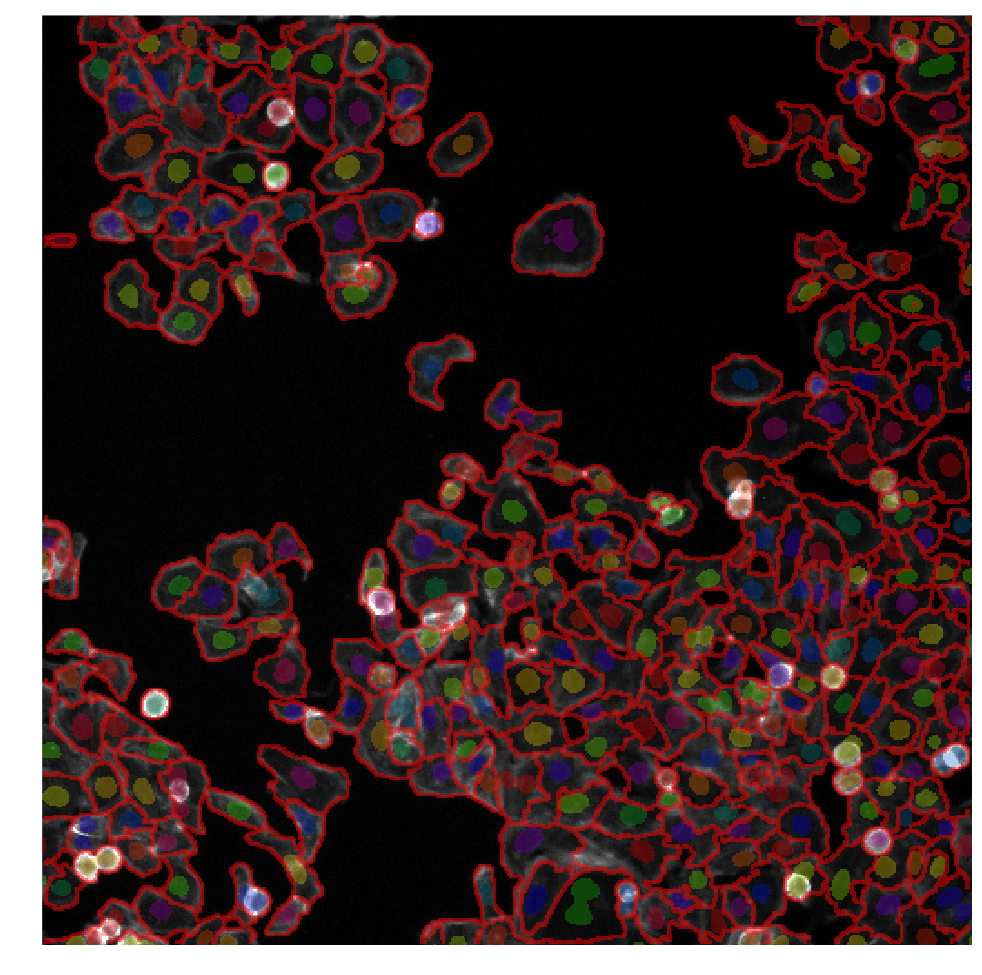

In [15]:
# Better visualization
fig = plt.figure(figsize=(12,12))
plt.imshow(act_bgsub, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(nuc_labeled, mask=nuc_labeled==0), interpolation='none', cmap='prism', alpha=0.3)
boundaries = filters.sobel(act_ws) > 0 
plt.imshow(np.ma.array(boundaries, mask=boundaries==0), interpolation='none', cmap='autumn', alpha=0.5)
plt.axis('off')
plt.show()

## 3. Data Extraction & Analysis

### 3a. Extracting Region Data

In [16]:
# Regionprops provides a number of measurements per label
nuc_props_nuc = measure.regionprops(nuc_labeled, intensity_image=nuc)  # Props for nuclear mask, nuc channel
nuc_props_pH3 = measure.regionprops(nuc_labeled, intensity_image=pH3)  # Props for nuclear mask, pH3 channel
nuc_props_act = measure.regionprops(nuc_labeled, intensity_image=act)  # Props for nuclear mask, act channel

In [17]:
# To better handle these, they can be transformed into dictionaries or pandas dataframes

# Function to convert to dict
def props2dict(props):
        
    # Get prop names (excluding non-scalar props!)
    propdict = {prop_name:[] for prop_name in props[0]
                if not (type(props[0][prop_name]) in [tuple, np.ndarray])}
    
    # For each prop name...
    for prop_name in propdict:
        
        # For each region...
        for region in props:
            
            # Add the corresponding value
            propdict[prop_name].append(region[prop_name])
        
        # Convert the values to an array
        propdict[prop_name] = np.array(propdict[prop_name])
        
    # Return results
    return propdict


# Converting nuc_props_pH3 and nuc_props_act to dicts
propdict_pH3 = props2dict(nuc_props_pH3)
propdict_act = props2dict(nuc_props_act)

# Converting nuc_props_nuc to a pandas df
propdf = pd.DataFrame(props2dict(nuc_props_nuc))
propdf = propdf.drop(['bbox_area', 'euler_number'], axis=1)

### 3b. Visualizing Region Data

In [18]:
propdf.head()

,area,convex_area,eccentricity,equivalent_diameter,extent,filled_area,label,major_axis_length,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity
0,62,63,0.682228,8.884866,0.885714,62,1,10.539464,63,50.564516,38,7.705818,0.034808,27.656854,0.984127
1,68,70,0.800956,9.304853,0.708333,68,2,12.004450,86,60.852941,32,7.187342,-1.131981,29.556349,0.971429
2,14,14,0.970761,4.222008,0.875000,14,3,8.246211,68,44.500000,23,1.979487,-0.000000,14.414214,1.000000
3,100,100,0.481447,11.283792,0.909091,100,4,12.178339,82,64.540000,47,10.674009,-0.266570,35.071068,1.000000
4,19,20,0.821527,4.918491,0.791667,19,5,6.674754,78,58.473684,39,3.805741,-1.231354,13.621320,0.950000


In [19]:
propdf.describe()

,area,convex_area,eccentricity,equivalent_diameter,extent,filled_area,label,major_axis_length,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,96.867314,102.103560,0.628048,10.869137,0.757966,96.867314,155.000000,13.022501,90.216828,63.861655,33.401294,9.374887,-0.000362,34.965115,0.960949
std,37.946457,45.262463,0.174455,2.283426,0.072096,37.946457,89.344838,3.821963,30.948453,15.505619,6.327696,2.161316,0.882324,9.846873,0.041579
min,1.000000,1.000000,0.000000,1.128379,0.423684,1.000000,1.000000,0.000000,34.000000,32.500000,18.000000,0.000000,-1.570796,0.000000,0.761404
25%,75.000000,78.000000,0.514392,9.772050,0.729167,75.000000,78.000000,11.000923,72.000000,54.181818,29.000000,8.558504,-0.727745,30.142136,0.955882
50%,91.000000,95.000000,0.622897,10.764051,0.765152,91.000000,155.000000,12.328147,83.000000,61.333333,33.000000,9.584957,0.017202,33.798990,0.970588
75%,115.000000,120.000000,0.757535,12.100518,0.805128,115.000000,232.000000,13.957039,97.000000,69.778409,37.000000,10.615047,0.707810,38.384776,0.981982
max,315.000000,382.000000,1.000000,20.026744,1.000000,315.000000,309.000000,33.334594,255.000000,133.231788,60.000000,17.185220,1.570796,80.769553,1.000000


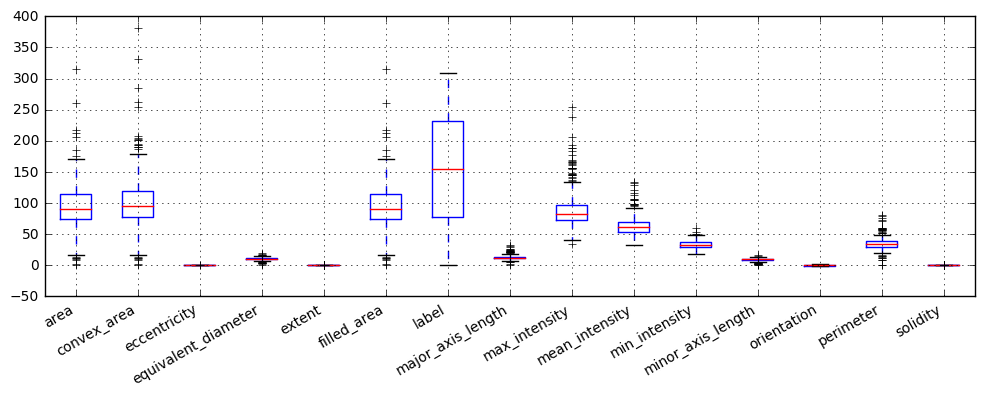

In [20]:
# Boxplot
fig = plt.figure(figsize=(12,4))
propdf.boxplot()
fig.autofmt_xdate()
plt.show()

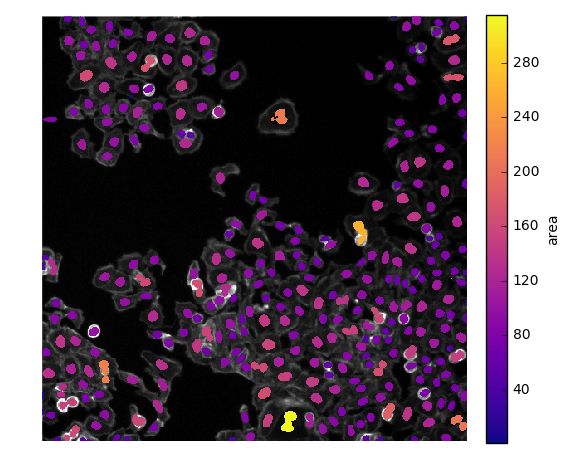

In [21]:
# Backmapping onto image
color_prop = 'area'
nuc_propcolored = np.zeros(nuc.shape)
for row,label in enumerate(propdf.label):
    nuc_propcolored[nuc_labeled==label] = propdict_act[color_prop][row]
    
# Show
fig = plt.figure(figsize=(6,6))
plt.imshow(act_bgsub, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(nuc_propcolored, mask=nuc_propcolored==0), 
           interpolation='none', cmap='plasma')
plt.colorbar(label=color_prop, fraction=0.046, pad=0.04)
plt.axis('off')
plt.show()

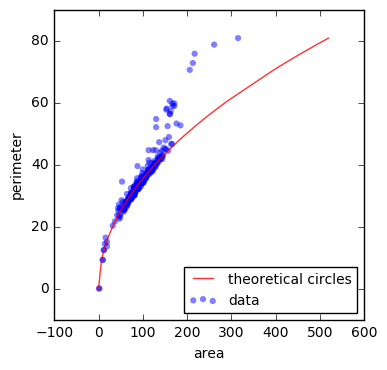

In [22]:
# Scatter plot to look at relations
fig = plt.figure(figsize=(4,4))
plt.scatter(propdf.area, propdf.perimeter, edgecolor='', alpha=0.5)
plt.plot(np.sort(propdf.perimeter)**2.0 / (4*np.pi), np.sort(propdf.perimeter), color='r', alpha=0.8)
plt.legend(['theoretical circles', 'data'], loc=4, fontsize=10)
plt.xlabel('area')
plt.ylabel('perimeter')
plt.show()

### 3b. Identifying Dividing Cells using a Support Vector Machine

Based on the **pH3 channel**, cells currently undergoing mitosis can be identified without any ambiguity. However, if the **Hoechst channel** holds enough information on its own to confidently classify cells as mitotic and non-mitotic, the pH3 channel is no longer needed and its wavelength is freed up for other purposes.

Here, we can use the pH3 channel to create a **ground truth** for the mitotic vs. non-mitotic classification. We can then use this to train a **support vector classifier** to identify mitotic cells without use of the pH3 channel.

**<font color=red>Warning:</font> This is just a mock example!** Larger datasets will feature many cases that are less clear-cut than the ones observed here, so much **more data would be needed** to train a robust classifier. In particular, many more cases of mitotic cells would be needed so that a **balanced** training set can be constructed. Furthermore, because of the lack of data in this example, the classifier's performance is evaluated on the training set itself, which means that overfitting goes unnoticed. **In a real case, it is imperative to evaluate classifiers on separate training and test sets!**

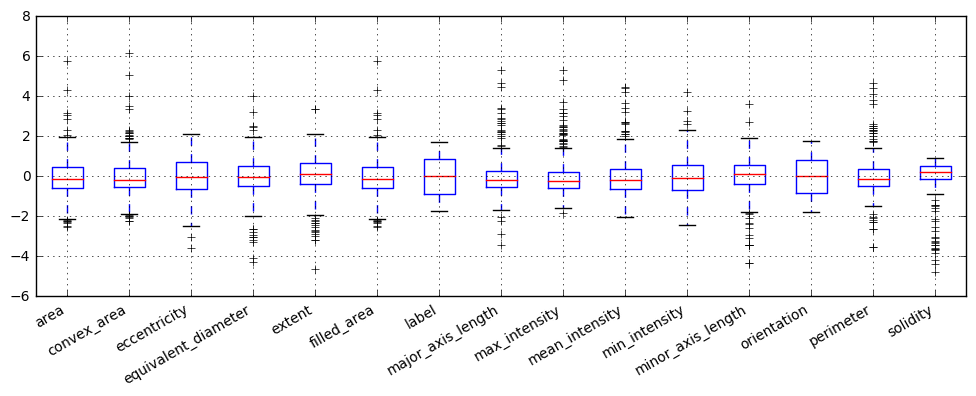

In [23]:
# Standardizing the features to zero mean and unit variance
propdf_stand = (propdf - propdf.mean()) / propdf.std()

# Show
fig = plt.figure(figsize=(12,4))
propdf_stand.boxplot()
fig.autofmt_xdate()
plt.show()

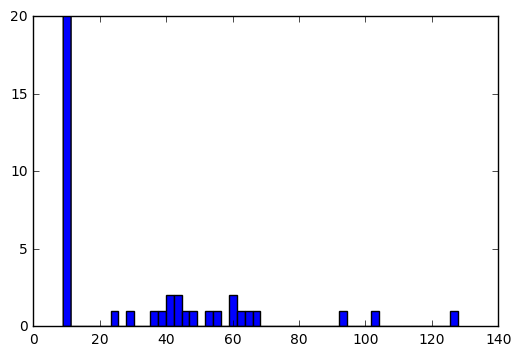

In [24]:
# Use pH3 signal to create ground truth labels (True: "in mitosis" | False: "not in mitosis") 

# Check pH3 signal distribution with histogram
plt.hist(propdict_pH3['mean_intensity'], bins=50)
plt.ylim([0,20])
plt.show()

# Create ground truth
ground_truth = propdict_pH3['mean_intensity'] > 20

In [25]:
# Train Support Vector Classifier
svc = svm.SVC()
svc.fit(propdf_stand, ground_truth)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# Predict on the training data
prediction = svc.predict(propdf_stand)

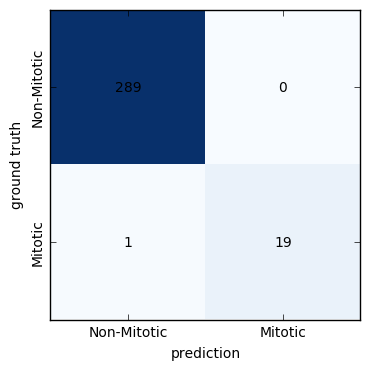

In [27]:
# Evaluate prediction with a confusion matrix
cmat = metrics.confusion_matrix(ground_truth, prediction)

# Show
plt.imshow(cmat,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cmat):
    plt.text(j, i, z, ha='center', va='center')
plt.xticks([0,1], ["Non-Mitotic","Mitotic"])
plt.yticks([0,1], ["Non-Mitotic","Mitotic"], rotation=90)
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.show()

## Resources for Further Study


- **Online resource:** The [scikit-image docs](http://scikit-image.org/docs/0.13.x/) contain a lot of information, including a [user guide](http://scikit-image.org/docs/0.13.x/user_guide.html) and an extensive [gallery of examples](http://scikit-image.org/docs/0.13.x/auto_examples/index.html#examples-gallery).


- **Online tutorial:** The materials from the EMBL Bio-IT Course [Python Workshop Image Processing](https://git.embl.de/grp-bio-it/python-workshop-image-processing) feature a self-explanatory tutorial pipeline.


- **Free E-Book:** [BioImage Data Analysis](http://www.imaging-git.com/olympus-website-bioimage-data-analysis), a comprehensive introduction to BioImage Data Analysis with Fiji and MATLAB, by Kota Miura (former EMBL Center for Microscopy and Image Analysis).


- **Online resource:** [OpenCV](http://docs.opencv.org/trunk/d1/dfb/intro.html) is a large library of image analysis algorithms that can be used with different programming languages. Tutorials on how to use OpenCV with Python can be found [here](http://docs.opencv.org/trunk/d6/d00/tutorial_py_root.html).


- **Online resource:** The [SciPy Docs for scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html) provide a (brief and technical) overview of the ndimage module, which tends to be useful when working with higher-dimensional images and complements scikit-image quite well.


- **Online resource:** [Mahotas](http://mahotas.readthedocs.io/en/latest/) is another python package for image analysis. It is largely redundant with scikit-image but built differently under the hood (with C++ instead of Cython), which can be advantageous in some cases.


- **Online resource:** Python (or more accurately Jython) can also be used as a macro language in [ImageJ](http://imagej.net/Welcome)/[Fiji](http://fiji.sc/). An introduction can be found [here](http://imagej.net/Jython_Scripting), though I believe it is currently being rewritten and therefore a mess. The old version is [here](http://imagej.net/Jython_Scripting_Examples).


- **<font color=green>Keep studying every week!</font> Join the [EMBL Coding Club!](https://bio-it.embl.de/coding-club/)**

## References

Jason Moffat, Dorre A. Grueneberg, Xiaoping Yang, So Young Kim, Angela M. Kloepfer, Gregory Hinkle, Bruno Piqani, Thomas M. Eisenhaure, Biao Luo, Jennifer K. Grenier, Anne E. Carpenter, Shi Yin Foo, Sheila A. Stewart, Brent R. Stockwell, Nir Hacohen, William C. Hahn, Eric S. Lander, David M. Sabatini, David E. Root (2006): *A Lentiviral RNAi Library for Human and Mouse Genes Applied to an Arrayed Viral High-Content Screen*, Cell 124:6, 1283-1298.